In [1]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import matplotlib.pyplot as plt

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# uncomment when SB3 & wandb are working together again
import wandb
from wandb.integration.sb3 import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grantbell. Use `wandb login --relogin` to force relogin


True

In [2]:
position_map = {0: 'QB', 1: 'RB', 2: 'WR', 3: 'TE'}
        
position_counts = {
    'QB': 1,
    'RB': 2,
    'WR': 2,
    'TE': 1,
    'FLEX': 1,
}

flex_positions = ['RB', 'WR', 'TE']

In [3]:
class FantasyFootballEnv(gym.Env):
    def __init__(self, teams=12, rounds=12, year=None, first_round_pick=None, data_first_year=2018, data_last_year=2022
                , apply_penalty=False, penalty_amt=-10, adp_variability=True):
        super(FantasyFootballEnv, self).__init__()
        
        # Action space: 0: QB, 1: RB, 2: WR, 3: TE
        self.action_space = spaces.Discrete(4)
        
        self.observation_space = spaces.Box(low=0, high=rounds, shape=(5,), dtype=np.int32)
        
        self.adp_variability = adp_variability
        
        # Other initializations
        self.current_round = 1
        self.roster = {'QB': [], 'RB': [], 'WR': [], 'TE': []}
        self.position_counts = position_counts
        self.flex_positions = flex_positions
        self.drafted_players = []
        
        self.data_first_year = data_first_year
        self.data_last_year = data_last_year
        self.teams = teams
        self.rounds = rounds
        if year is not None:
            self.year = year
        else:
            self.year = random.randint(2018, 2022)
        if first_round_pick is not None:
            self.first_round_pick = first_round_pick
        else:
            self.first_round_pick = random.randint(1, teams)  
        self.pick = self.first_round_pick
        self.adp_adj = self.calc_adp_adj()
            
        self.player_df = self.create_player_df()
        
        # print(f'Year: {self.year}, First Round Pick: {self.first_round_pick}, Teams: {self.teams}, Rounds: {self.rounds}')
        
    def reset(self, seed=None, year=None, first_round_pick=None):
        
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        
        if year is not None:
            self.year = year
        else:
            self.year = random.randint(2018, 2022)
        if first_round_pick is not None:
            self.first_round_pick = first_round_pick
        else:
            self.first_round_pick = random.randint(1, self.teams)
        self.pick = self.first_round_pick
        self.adp_adj = self.calc_adp_adj()
            
        self.flex_count = 0

        self.current_round = 1
        self.roster = {'QB': [], 'RB': [], 'WR': [], 'TE': []}
        self.drafted_players = []
        
        # Create the initial observation with the current round and counts for each position
        observation = [self.current_round, len(self.roster['QB']), len(self.roster['RB']), len(self.roster['WR']), len(self.roster['TE'])]
                
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        info = {}
        
        # print(f'Year: {self.year}, First Round Pick: {self.first_round_pick}, Teams: {self.teams}, Rounds: {self.rounds}')

                
        return observation, info
    
    def step(self, action):
        
        done = False
        reward = 0
        
        selected_position = position_map[action]
        
        selected_player, selected_player_points = self.draft_player(selected_position)
        self.roster[selected_position].append(selected_player)
                
        if self.current_round >= self.rounds:
            done = True
            total_points = self.calculate_total_points()
            reward += total_points
        
        info = {}
        info.update({
            'round': self.current_round,
            'pick': self.pick,
            'adp_adj': self.adp_adj,
            'selected_position': selected_position,
            'selected_player': selected_player,
            'selected_player_points': selected_player_points,
            'reward': reward,
            
        })
        
        self.current_round += 1
        self.pick = self.snake_draft_pick()
        self.adp_adj = self.calc_adp_adj()
        
        observation = [self.current_round, len(self.roster['QB']), len(self.roster['RB']), len(self.roster['WR']), len(self.roster['TE'])]

                
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        return observation, reward, done, False, info
    
    def create_player_df(self):

        player_adp_df = pd.read_csv(f'adp_{self.data_first_year}_{self.data_last_year}.csv')
        player_adp_df = player_adp_df[player_adp_df['Player'].notna()]
        player_adp_df = player_adp_df[player_adp_df['Year'] == self.year]
        player_adp_df['Player'] = player_adp_df['Player'].apply(lambda x: ' '.join(str(x).split()[:2]))
        
        player_performance_df = pd.read_csv(f'player_performance_{self.data_first_year}_{self.data_last_year}.csv')
        player_performance_df = player_performance_df[player_performance_df['Player'].notna()]
        player_performance_df = player_performance_df[player_performance_df['year'] == self.year]
        player_performance_df['Player'] = player_performance_df['Player'].apply(lambda x: ' '.join(str(x).split()[:2]))
        
        player_df = pd.merge(player_adp_df, player_performance_df, on='Player', how='inner')
        player_df['Position'] = player_df['Position'].apply(lambda x: x[:2])        
        player_df['Position'] = player_df['Position'].str[:2]        
        player_df= player_df[['Player', 'Position', 'Rank_x', 'AVG', 'FPTS']]
        
        return player_df
        
    def snake_draft_pick(self):
        if self.current_round % 2 == 1:
            pick = (self.current_round - 1) * self.teams + self.first_round_pick
        else:
            pick = (self.current_round - 1) * self.teams + (self.teams - self.first_round_pick + 1)
        return pick

    
    def calc_adp_adj(self):
        if self.adp_variability:
            if self.current_round == 1:
                adp_adj = random.randint(int(-(self.first_round_pick - 1)/2), int((self.first_round_pick - 1)/2))
            elif self.current_round == 2:
                adp_adj = random.randint(int(-self.teams/2), int(self.teams/2))
            else:
                adp_adj = random.randint(-self.teams, self.teams)
        else:
            adp_adj = 0
        return adp_adj
    
    
    def draft_player(self, selected_position):
                
        available_players = self.player_df[(self.player_df['Position'] == selected_position) & (self.player_df['Rank_x'] >= (self.pick + self.adp_adj)) & (~self.player_df['Player'].isin(self.drafted_players))]  # Filter out players who have already been drafted
        
        selected_player_df = available_players.nsmallest(1, 'AVG')
        selected_player = selected_player_df['Player'].iloc[0]
        selected_player_points = selected_player_df['FPTS'].iloc[0]
        
        self.drafted_players.append(selected_player)
        
        return selected_player, selected_player_points
    
    def custom_policy(self):
            
        pos_max = {
            'QB': 2,
            'TE': 2,
        }
        
        ineligible_positions = []
        
        for pos in pos_max.keys():
            if len(self.roster[pos]) >= pos_max[pos]:
                ineligible_positions.append(pos)
        
        mask1 = ~self.player_df['Position'].isin(ineligible_positions)
        mask2 = self.player_df['Rank_x'] >= (self.pick + self.adp_adj)
        mask3 = ~self.player_df['Player'].isin(self.drafted_players)
        available_players = self.player_df[mask1 & mask2 & mask3]
                
        undrafted_positions = []
        if self.current_round == self.rounds-2:
            for pos in self.position_counts.keys():
                if pos == 'FLEX':
                    continue
                elif len(self.roster[pos]) < self.position_counts[pos]:
                    undrafted_positions.append(pos)
            if len(undrafted_positions) >= 3:
                available_players = available_players[available_players['Position'].isin(undrafted_positions)]
        if self.current_round == self.rounds-1:
            for pos in self.position_counts.keys():
                if pos == 'FLEX':
                    continue
                elif len(self.roster[pos]) < self.position_counts[pos]:
                    undrafted_positions.append(pos)
            if len(undrafted_positions) >= 2:
                available_players = available_players[available_players['Position'].isin(undrafted_positions)]
        if self.current_round == self.rounds:
            for pos in self.position_counts.keys():
                if pos == 'FLEX':
                    continue
                elif len(self.roster[pos]) < self.position_counts[pos]:
                    undrafted_positions.append(pos)
            if len(undrafted_positions) >= 1:
                available_players = available_players[available_players['Position'].isin(undrafted_positions)]
        
        
        selected_player_df = available_players.nsmallest(1, 'AVG')
        selected_player_position = selected_player_df['Position'].iloc[0]
        
        key_found = None

        for key, value in position_map.items():
            if value == selected_player_position:
                action = key
                break
                    
        return action
    
    def calculate_total_points(self):
        
        # note this method assumes you play your best player not the order they are drafted
        
        total_points = 0
        
        for pos in self.roster.keys():
            pos_points_list = [self.player_df[self.player_df['Player'] == player]['FPTS'].iloc[0] for player in self.roster[pos]]
            pos_points_list = sorted(pos_points_list, reverse=True)[:self.position_counts[pos]]
            total_points += sum(pos_points_list)
            
        flex_points_list = []
        for pos in self.flex_positions:
            pos_points_list = [self.player_df[self.player_df['Player'] == player]['FPTS'].iloc[0] for player in self.roster[pos]]
            pos_points_list = sorted(pos_points_list, reverse=True)[self.position_counts[pos]:]
            flex_points_list+=pos_points_list        
        flex_points_list = sorted(flex_points_list, reverse=True)[:self.position_counts['FLEX']]
        
        total_points+=sum(flex_points_list)
        
        return total_points

In [4]:
def run_training_job(model_type
                    , use_wandb = 'y', wandb_verbose=2
                    , timesteps=1_000_000
                    # , policy='MultiInputPolicy'
                    , policy='MlpPolicy'
                    , n_eval_episodes=12
                    , vec_envs='n', n_envs=4
                    , sb3_model_verbose=0
                    # DQN
                    , dqn_exploration_final_eps=0.025, dqn_exploration_fraction=0.5
                    # PPO
                    # https://colab.research.google.com/drive/1GI0WpThwRHbl-Fu2RHfczq6dci5GBDVE#scrollTo=FMdJRrZ4n7xp
                    , ppo_n_steps = 1024, ppo_batch_size = 64, ppo_n_epochs = 4, ppo_gamma = 0.999, ppo_gae_lambda = 0.98, ppo_ent_coef = 0.01
                    , name_suffix = ''
                    ):
    
    config = {
    "policy_type": policy,
    "total_timesteps": timesteps,
    # "env_id": "NflEnv",
    "env_id": "FantasyFootballEnv",
    }

    # https://stable-baselines3.readthedocs.io/en/master/guide/integrations.html
    if use_wandb == 'y':
        run = wandb.init(
            # project="sb3_nfl_2",
            project="sb3_FantasyFootballEnv",
            config=config,
            sync_tensorboard=True
        )

    # when using multiple environments, the total number of steps taken in counts each step taken in each environment
    # if using 4 environments and 400_000 TIMESTEPS, the agent will take a total of 100_000 steps in each environment.
    if vec_envs == 'y':
        # https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb
        # received 'ValueError: high is out of bounds for int32' without the seed
        # env = make_vec_env(env_id = NflEnv, n_envs=n_envs, seed=1)
        # eval_env = make_vec_env(env_id = NflEnv, n_envs=1, seed=1)
        env = make_vec_env(env_id = FantasyFootballEnv, n_envs=n_envs, seed=1)
        eval_env = make_vec_env(env_id = FantasyFootballEnv, n_envs=1, seed=1)

    elif vec_envs == 'n':
        # env = NflEnv()
        # eval_env = NflEnv()
        env = FantasyFootballEnv()
        eval_env = FantasyFootballEnv()
    
    if use_wandb == 'y':
        if model_type == 'DQN':
            # default values for these parameters are exploration_final_eps=0.05 and exploration_fraction=0.1
            # with the default values, the exploration rate will linearly decrease to 0.05 over the first 10% of the timesteps
            model = DQN(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}"
                        , exploration_final_eps=dqn_exploration_final_eps, exploration_fraction = dqn_exploration_fraction)
        elif model_type == 'PPO':
            model = PPO(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}"
                        , n_steps = ppo_n_steps, batch_size = ppo_batch_size, n_epochs = ppo_n_epochs, gamma = ppo_gamma
                        , gae_lambda = ppo_gae_lambda, ent_coef = ppo_ent_coef)
        elif model_type == 'A2C':
            model = A2C(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}")
    else:
        if model_type == 'DQN':
            model = DQN(config["policy_type"], env, verbose=sb3_model_verbose, exploration_final_eps=dqn_exploration_final_eps
                        , exploration_fraction = dqn_exploration_fraction)
        elif model_type == 'PPO':
            model = PPO(config["policy_type"], env, verbose=sb3_model_verbose
                        , n_steps = ppo_n_steps, batch_size = ppo_batch_size, n_epochs = ppo_n_epochs, gamma = ppo_gamma
                        , gae_lambda = ppo_gae_lambda, ent_coef = ppo_ent_coef)
        elif model_type == 'A2C':
            model = A2C(config["policy_type"], env, verbose=sb3_model_verbose)

    mean_reward, std_reward = evaluate_policy(model=model, env=eval_env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward before training:{mean_reward:.2f} +/- {std_reward:.2f}")

    if use_wandb == 'y':
        model.learn(
            total_timesteps=config["total_timesteps"],
            callback=WandbCallback(
                model_save_path=f"models/{run.id}",
                verbose=wandb_verbose,
            ),
        )
        run.finish()
    else:
        model.learn(total_timesteps=config["total_timesteps"])

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward after training:{mean_reward:.2f} +/- {std_reward:.2f}")

    # parameters_saved = model.get_parameters()
    
    if vec_envs == 'y':
        model.save(f"models/{model_type}_{timesteps}_{n_envs}Envs{name_suffix}")
    else:
        model.save(f"models/{model_type}_{timesteps}_1Envs{name_suffix}")
    
    return model

In [15]:
model_type = 'PPO'
time_steps = 500_000
model = run_training_job(model_type,timesteps=time_steps, use_wandb='n', ppo_gamma=1)

c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward before training:787.91 +/- 123.02


c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward after training:1240.09 +/- 132.49


In [16]:
model_type = 'PPO'
time_steps = 1_000_000
model = run_training_job(model_type,timesteps=time_steps, use_wandb='n', ppo_gamma=1)

c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward before training:999.92 +/- 73.98


c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward after training:1383.82 +/- 152.80


In [10]:
model_type = 'PPO'
time_steps = 1_000_000
model = run_training_job(model_type, timesteps=time_steps, use_wandb='n', ppo_gamma=1, vec_envs='y')

mean_reward before training:778.20 +/- 99.81
mean_reward after training:1264.32 +/- 106.90


In [5]:
model_type = 'PPO'
time_steps = 1_500_000
model = run_training_job(model_type, timesteps=time_steps, use_wandb='n', ppo_gamma=1, vec_envs='y', n_envs=6)

mean_reward before training:612.00 +/- 56.74
mean_reward after training:1191.91 +/- 181.64


In [7]:
def draft(teams=12, rounds=12, first_round_pick=None, year=None
        , model=None, deterministic=True
        , actions=None
        , custom_policy=False
        , print_round=True, print_score=True
        , adp_variability=False):
    env = FantasyFootballEnv(teams=teams, rounds=rounds, first_round_pick=first_round_pick, year=year, adp_variability=adp_variability)
    state, info = env.reset(first_round_pick=first_round_pick, year=year)
    
    round_nums = []
    picks = []
    positions = []
    players = []
    points = []
    
    for i in range(rounds):
        if model is not None:
            action, _states = model.predict(state, deterministic=deterministic)
            action = int(action)  # If action is an array with a single value that can be directly converted to int
        elif actions is not None:
            action = actions[i]
        
        elif custom_policy:
            action = env.custom_policy()
        
        new_state, reward, done, placeholder, info = env.step(action)
        
        round_num = info['round']
        pick = info['pick']
        position = info['selected_position']
        player = info['selected_player']
        point = info['selected_player_points']
        
        round_nums.append(round_num)
        picks.append(pick)
        positions.append(position)
        players.append(player)
        points.append(point)
        
        if print_round:
            print(f'Round {round_num}, Pick {pick}, adp_adj {info["adp_adj"]}, Pos {position}, Player {player}, points {point}, reward {info["reward"]}')
        if print_score:
            if done:
                print(f'year {year}, First Pick {first_round_pick}, total score: {reward}\n')
                
        state = new_state
        
    df = pd.DataFrame({
        'year': year,
        'first_round_pick': first_round_pick,
        'round': round_nums,
        'pick': picks,
        'position': positions,
        'player': players,
        'points': points
    })
    
    return reward, df

def drafts(first_year=2018, last_year=2022, teams=12, actions=None, custom_policy=False, model=None):
    dfs = []
    years =[]
    picks = []
    scores = []
    for year in range(first_year, last_year+1):
        for first_round_pick in range (1, teams+1):
            score, df = draft(first_round_pick=first_round_pick, year=year, teams=teams
                        , actions=actions, custom_policy=custom_policy, model=model
                        , print_round=False, print_score=False)
            
            years.append(year)
            picks.append(first_round_pick)
            scores.append(score)
            dfs.append(df)
    avg = np.mean(scores)
    std = np.std(scores)
    print(f'avg: {avg}, std: {std}')
    
    df = pd.concat(dfs, ignore_index=True)
    
    df['position_rank'] = df.groupby(['year', 'first_round_pick', 'position'])['points'].rank(method='first', ascending=False)
    df['start'] = False
    df['potential_flex_start'] = False
    for pos in position_counts.keys():
        if pos == 'FLEX': continue
        else:
            pos_mask = df['position'] == pos
            starter_mask = df['position_rank'] <= position_counts[pos]
            df.loc[pos_mask & starter_mask, 'start'] = True
            if pos in flex_positions:
                flex_mask = df['position_rank'] > position_counts[pos]
                df.loc[pos_mask & flex_mask, 'potential_flex_start'] = True
                
    df['potential_flex_rank'] = df[df['potential_flex_start'] == True].groupby(['year', 'first_round_pick'])['points'].rank(method='first', ascending=False)
    df['flex_start'] = False
    
    flex_start_mask = df['potential_flex_rank'] <= position_counts['FLEX']
    df.loc[flex_start_mask, 'start'] = True
    df.loc[flex_start_mask, 'flex_start'] = True
    df.drop('potential_flex_start', axis=1, inplace=True)
    df.drop('potential_flex_rank', axis=1, inplace=True)
    df['flex_rank'] = df[df['flex_start'] == True].groupby(['year', 'first_round_pick', 'position'])['points'].rank(method='first', ascending=False)
    df['roster_position'] = np.nan
    df.loc[(df['start'] == True) & (df['flex_start'] == False), 'roster_position'] = df['position'] + df['position_rank'].astype(int).astype(str)
    mask = (df['flex_start'] == True) & (~df['flex_rank'].isna())
    df.loc[mask, 'roster_position'] = 'FLEX' + df.loc[mask, 'flex_rank'].astype(int).astype(str)
    df.drop('flex_rank', axis=1, inplace=True)
    
    df['team_points'] = np.nan
    df['team_points'] = df['points'].where(df['start'], 0)
    
    grouped_points = df.groupby(['year', 'first_round_pick']).agg({
    'points': 'sum',
    'team_points': 'sum'
    }).reset_index()
    grouped_points['round'] = 'total'
    grouped_points['pick'] = 'total'
    grouped_points['position'] = 'total'
    grouped_points['player'] = 'total'
    grouped_points['roster_position'] = 'total'
    total_rows = grouped_points[['year', 'first_round_pick', 'round', 'pick', 'position', 'player', 'points', 'team_points', 'roster_position']]
    df = pd.concat([df, total_rows], ignore_index=True).sort_values(by=['year', 'first_round_pick'])
    
    return df

In [8]:
year = random.randint(2018, 2022)
first_round_pick = random.randint(1, 12)
print(f'Year: {year}, First Round Pick: {first_round_pick}')

Year: 2021, First Round Pick: 12


In [7]:
print("manual")
actions = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 3]
draft(first_round_pick=first_round_pick, year=year, actions=actions)
df = drafts(actions=actions)
df.to_csv(f'data/drafts/manual.csv', index=False)

manual
Round 1, Pick 12, adp_adj 0, Pos RB, Player Dalvin Cook, points 132.0, reward 0
Round 2, Pick 13, adp_adj 0, Pos WR, Player Julio Jones, points 269.4, reward 0
Round 3, Pick 36, adp_adj 0, Pos RB, Player Jay Ajayi, points 40.9, reward 0
Round 4, Pick 37, adp_adj 0, Pos WR, Player Larry Fitzgerald, points 151.2, reward 0
Round 5, Pick 60, adp_adj 0, Pos RB, Player Tevin Coleman, points 177.6, reward 0
Round 6, Pick 61, adp_adj 0, Pos WR, Player Alshon Jeffery, points 152.8, reward 0
Round 7, Pick 84, adp_adj 0, Pos RB, Player Tarik Cohen, points 198.4, reward 0
Round 8, Pick 85, adp_adj 0, Pos WR, Player Cooper Kupp, points 115.1, reward 0
Round 9, Pick 108, adp_adj 0, Pos RB, Player C.J. Anderson, points 64.9, reward 0
Round 10, Pick 109, adp_adj 0, Pos WR, Player Kenny Stills, points 115.9, reward 0
Round 11, Pick 132, adp_adj 0, Pos QB, Player Derek Carr, points 216.3, reward 0
Round 12, Pick 133, adp_adj 0, Pos TE, Player Tyler Eifert, points 31.4, reward 1197.1000000000001
y

In [8]:
print("custom policy")
draft(first_round_pick=first_round_pick, year=year, custom_policy=True, rounds=12)
df = drafts(custom_policy=True)
df.to_csv(f'data/drafts/custom.csv', index=False)

custom policy
Round 1, Pick 12, adp_adj 0, Pos WR, Player Odell Beckham, points 191.9, reward 0
Round 2, Pick 13, adp_adj 0, Pos WR, Player Julio Jones, points 269.4, reward 0
Round 3, Pick 36, adp_adj 0, Pos WR, Player Amari Cooper, points 178.0, reward 0
Round 4, Pick 37, adp_adj 0, Pos WR, Player Larry Fitzgerald, points 151.2, reward 0
Round 5, Pick 60, adp_adj 0, Pos TE, Player Greg Olsen, points 66.6, reward 0
Round 6, Pick 61, adp_adj 0, Pos WR, Player Alshon Jeffery, points 152.8, reward 0
Round 7, Pick 84, adp_adj 0, Pos QB, Player Kirk Cousins, points 282.6, reward 0
Round 8, Pick 85, adp_adj 0, Pos WR, Player Cooper Kupp, points 115.1, reward 0
Round 9, Pick 108, adp_adj 0, Pos QB, Player Ben Roethlisberger, points 341.5, reward 0
Round 10, Pick 109, adp_adj 0, Pos RB, Player C.J. Anderson, points 64.9, reward 0
Round 11, Pick 132, adp_adj 0, Pos WR, Player DeSean Jackson, points 130.8, reward 0
Round 12, Pick 133, adp_adj 0, Pos RB, Player Bilal Powell, points 54.8, reward 

In [8]:
time_steps = 500_000
model_type = 'PPO'
envs = 1
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=1, year=2022, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 500000 time_steps
Round 1, Pick 1, adp_adj 0, Pos TE, Player Travis Kelce, points 261.3, reward 0
Round 2, Pick 24, adp_adj 0, Pos RB, Player Ezekiel Elliott, points 177.3, reward 0
Round 3, Pick 25, adp_adj 0, Pos QB, Player Patrick Mahomes, points 428.9, reward 0
Round 4, Pick 48, adp_adj 0, Pos WR, Player Diontae Johnson, points 137.7, reward 0
Round 5, Pick 49, adp_adj 0, Pos RB, Player Josh Jacobs, points 301.8, reward 0
Round 6, Pick 72, adp_adj 0, Pos WR, Player Adam Thielen, points 145.0, reward 0
Round 7, Pick 73, adp_adj 0, Pos RB, Player Damien Harris, points 82.4, reward 1534.4
year 2022, First Pick 1, total score: 1534.4

avg: 1281.335, std: 195.31218670374872


In [9]:
time_steps = 1_000_000
model_type = 'PPO'
envs = 1
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=1, year=2022, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 1000000 time_steps
Round 1, Pick 1, adp_adj 0, Pos TE, Player Travis Kelce, points 261.3, reward 0
Round 2, Pick 24, adp_adj 0, Pos RB, Player Ezekiel Elliott, points 177.3, reward 0
Round 3, Pick 25, adp_adj 0, Pos QB, Player Patrick Mahomes, points 428.9, reward 0
Round 4, Pick 48, adp_adj 0, Pos WR, Player Diontae Johnson, points 137.7, reward 0
Round 5, Pick 49, adp_adj 0, Pos WR, Player Jaylen Waddle, points 221.7, reward 0
Round 6, Pick 72, adp_adj 0, Pos RB, Player Chase Edmonds, points 66.2, reward 0
Round 7, Pick 73, adp_adj 0, Pos WR, Player Adam Thielen, points 145.0, reward 1438.1
year 2022, First Pick 1, total score: 1438.1

avg: 1278.7666666666667, std: 159.2797273841073


In [9]:
time_steps = 1_000_000
model_type = 'PPO'
envs = 4
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=6, year=2018, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 1000000 time_steps
Round 1, Pick 6, adp_adj 0, Pos WR, Player DeAndre Hopkins, points 276.0, reward 0
Round 2, Pick 19, adp_adj 0, Pos RB, Player Jordan Howard, points 170.0, reward 0
Round 3, Pick 30, adp_adj 0, Pos RB, Player Alex Collins, points 101.1, reward 0
Round 4, Pick 43, adp_adj 0, Pos WR, Player Josh Gordon, points 118.2, reward 0
Round 5, Pick 54, adp_adj 0, Pos RB, Player Marshawn Lynch, points 71.5, reward 0
Round 6, Pick 67, adp_adj 0, Pos QB, Player Drew Brees, points 304.3, reward 0
Round 7, Pick 78, adp_adj 0, Pos WR, Player Devin Funchess, points 100.9, reward 0
Round 8, Pick 91, adp_adj 0, Pos TE, Player Jordan Reed, points 92.8, reward 0
Round 9, Pick 102, adp_adj 0, Pos QB, Player Philip Rivers, points 284.9, reward 0
Round 10, Pick 115, adp_adj 0, Pos TE, Player Jack Doyle, points 47.5, reward 0
Round 11, Pick 126, adp_adj 0, Pos WR, Player Kenny Golladay, points 172.1, reward 0
Round 12, Pick 139, adp_adj 0, Pos TE, Player Cameron Brate, points 77.9, rewa

In [9]:
time_steps = 1_500_000
model_type = 'PPO'
envs = 6
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=6, year=2018, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 1500000 time_steps
Round 1, Pick 6, adp_adj 0, Pos WR, Player DeAndre Hopkins, points 276.0, reward 0
Round 2, Pick 19, adp_adj 0, Pos WR, Player Davante Adams, points 274.1, reward 0
Round 3, Pick 30, adp_adj 0, Pos QB, Player Aaron Rodgers, points 312.5, reward 0
Round 4, Pick 43, adp_adj 0, Pos TE, Player Jimmy Graham, points 103.1, reward 0
Round 5, Pick 54, adp_adj 0, Pos WR, Player Chris Hogan, points 88.7, reward 0
Round 6, Pick 67, adp_adj 0, Pos WR, Player Marquise Goodwin, points 75.9, reward 0
Round 7, Pick 78, adp_adj 0, Pos RB, Player Ronald Jones, points 17.2, reward 0
Round 8, Pick 91, adp_adj 0, Pos RB, Player Chris Carson, points 191.4, reward 0
Round 9, Pick 102, adp_adj 0, Pos RB, Player Duke Johnson, points 108.5, reward 0
Round 10, Pick 115, adp_adj 0, Pos RB, Player Adrian Peterson, points 179.0, reward 0
Round 11, Pick 126, adp_adj 0, Pos RB, Player Devontae Booker, points 68.8, reward 0
Round 12, Pick 139, adp_adj 0, Pos RB, Player Theo Riddick, points 86.

In [10]:
columns=['year', 'first_round_pick', 'roster_position', 'round', 'pick', 'player', 'team_points']
left_csv = 'data/drafts/PPO_1000000_4Envs.csv'
right_csv = 'data/drafts/custom.csv'
def compare(left_csv, right_csv, first_year=2018, last_year=2022, teams=12):
    df_left = pd.read_csv(left_csv)
    df_left= pd.DataFrame(df_left, columns=columns)
    df_right = pd.read_csv(right_csv)
    df_right= pd.DataFrame(df_right, columns=columns)
    # drop bench players
    df_left.dropna(inplace=True)
    df_right.dropna(inplace=True)
    df = df_left.merge(df_right, how='inner', on=['year', 'first_round_pick', 'roster_position'], suffixes=('_a', '_b'))
    df['difference'] = df['team_points_a'] - df['team_points_b']
    dfs = []
    for year in range(first_year, last_year+1):
        for first_round_pick in range(1, teams+1):
            df2 = df[(df['year'] == year) & (df['first_round_pick'] == first_round_pick)]
            dfs.append(df2)
    df = pd.concat(dfs)
    df.to_csv('data/drafts/ppo_vs_custom.csv', index=False)
compare(left_csv, right_csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided files
custom_df = pd.read_csv('data/drafts/custom.csv')
ppo_df = pd.read_csv('data/drafts/PPO_1000000_4Envs.csv')
# Filter data for rows where round is 'Total'
custom_total = custom_df[custom_df['round'] == 'total']
ppo_total = ppo_df[ppo_df['round'] == 'total']

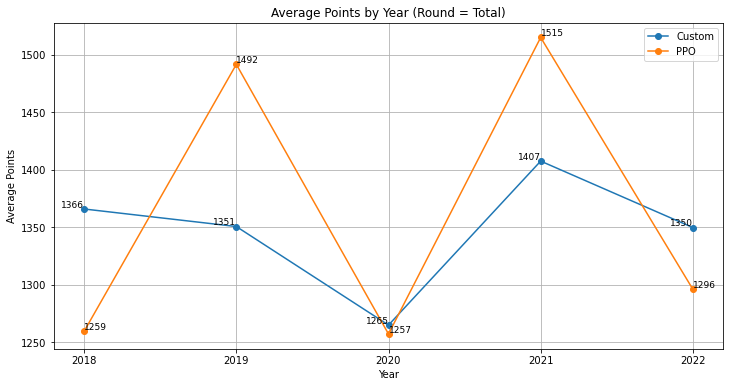

In [2]:
custom_avg = custom_total.groupby('year')['team_points'].mean()
ppo_avg = ppo_total.groupby('year')['team_points'].mean()

# Plot the average points by year with labeled points
plt.figure(figsize=(12, 6))

# Plot and label for custom data
custom_avg.plot(label='Custom', marker='o')
for x, y in custom_avg.items():
    plt.text(x, y, f'{y:.0f}', ha='right', va='bottom', fontsize=9)

# Plot and label for PPO data
ppo_avg.plot(label='PPO', marker='o')
for x, y in ppo_avg.items():
    plt.text(x, y, f'{y:.0f}', ha='left', va='bottom', fontsize=9)


plt.title('Average Points by Year (Round = Total)')
plt.xlabel('Year')
plt.ylabel('Average Points')
plt.xticks(ticks=custom_avg.index)  # Setting x-ticks to display only whole years
plt.legend()
plt.grid(True)
plt.show()

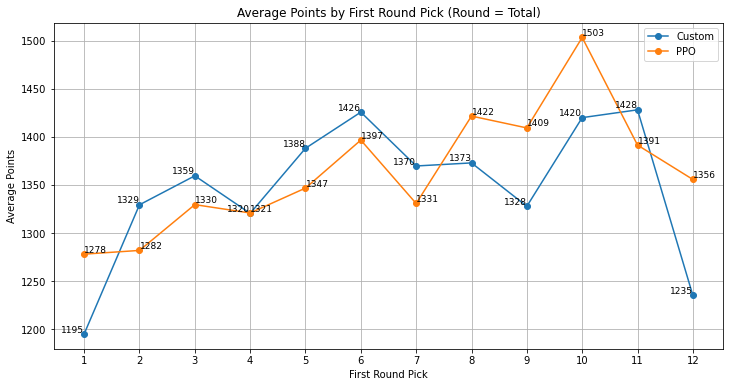

In [3]:
custom_avg = custom_total.groupby('first_round_pick')['team_points'].mean()
ppo_avg = ppo_total.groupby('first_round_pick')['team_points'].mean()

# Plot the average points by year with labeled points
plt.figure(figsize=(12, 6))

# Plot and label for custom data
custom_avg.plot(label='Custom', marker='o')
for x, y in custom_avg.items():
    plt.text(x, y, f'{y:.0f}', ha='right', va='bottom', fontsize=9)

# Plot and label for PPO data
ppo_avg.plot(label='PPO', marker='o')
for x, y in ppo_avg.items():
    plt.text(x, y, f'{y:.0f}', ha='left', va='bottom', fontsize=9)


plt.title('Average Points by First Round Pick (Round = Total)')
plt.xlabel('First Round Pick')
plt.ylabel('Average Points')
plt.xticks(ticks=custom_avg.index)  # Setting x-ticks to display only whole years
plt.legend()
plt.grid(True)
plt.show()

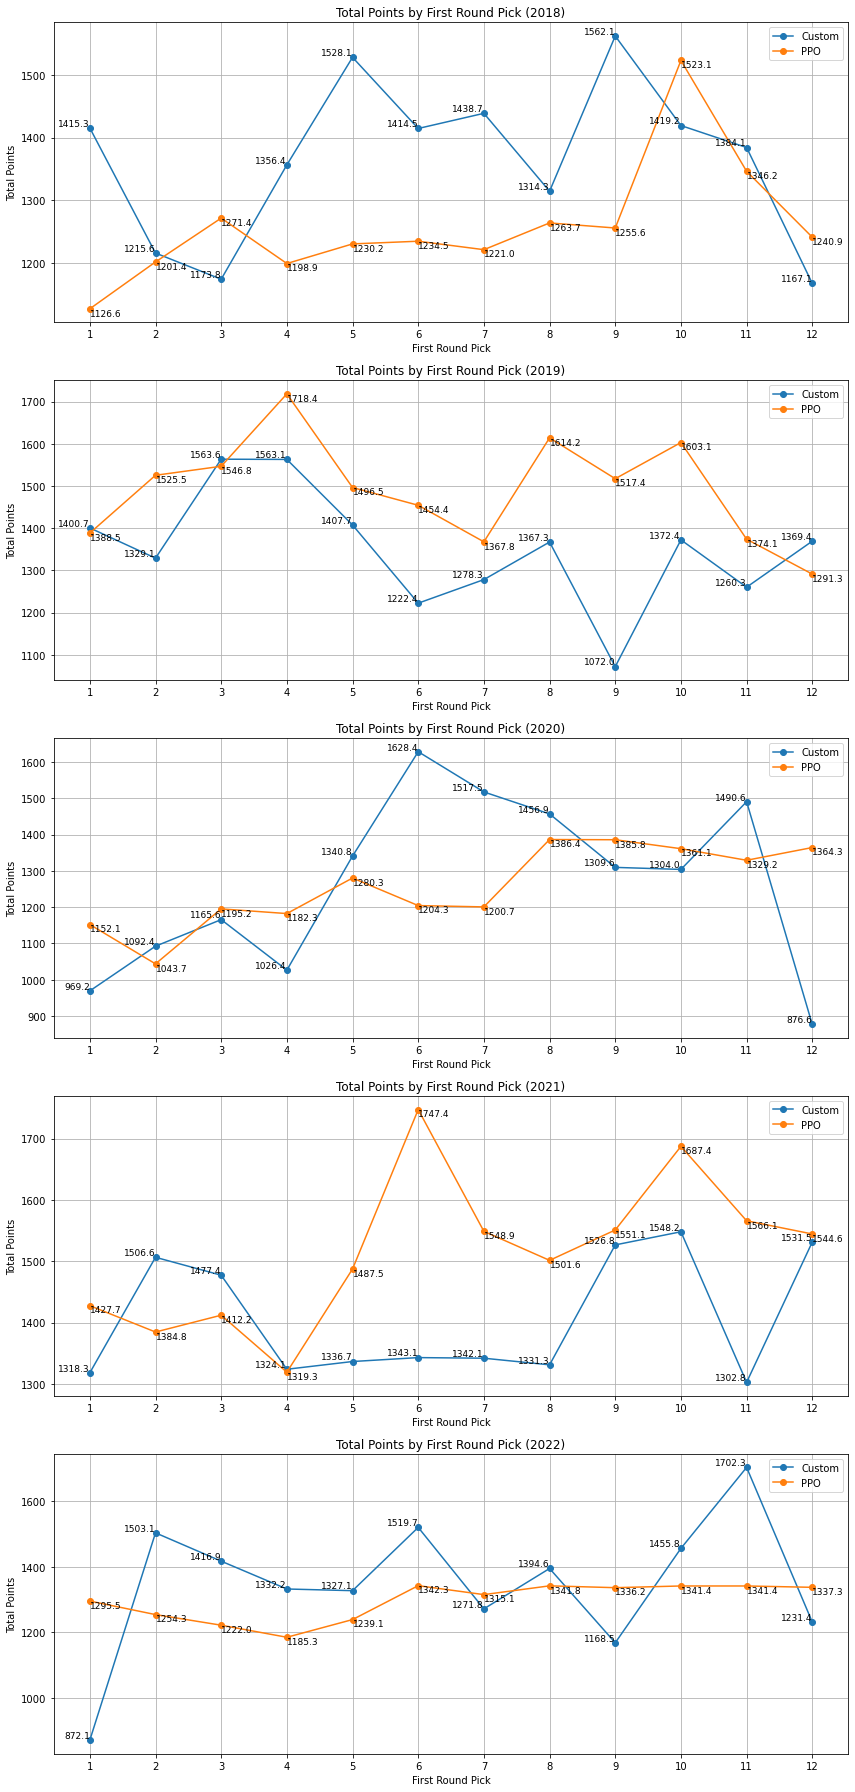

In [4]:
custom_grouped = custom_total.groupby(['year', 'first_round_pick'])['team_points'].sum().unstack()
ppo_grouped = ppo_total.groupby(['year', 'first_round_pick'])['team_points'].sum().unstack()

# Define the 'years' variable
years = custom_df['year'].unique()

# Plotting combined data for each year
fig, axes = plt.subplots(len(years), 1, figsize=(12, 5 * len(years)))

for i, year in enumerate(years):
    ax = axes[i]
    custom_grouped.loc[year].plot(ax=ax, label='Custom', marker='o')
    ppo_grouped.loc[year].plot(ax=ax, label='PPO', marker='o')
    
    # Adding labels for each point
    for x, y in custom_grouped.loc[year].items():
        ax.text(x, y, f'{y:.1f}', ha='right', va='bottom', fontsize=9)
    for x, y in ppo_grouped.loc[year].items():
        ax.text(x, y, f'{y:.1f}', ha='left', va='top', fontsize=9)
        
    # Set x-axis labels to display every pick number
    ax.set_xticks(custom_grouped.columns)
    
    ax.set_title(f'Total Points by First Round Pick ({year})')
    ax.set_xlabel('First Round Pick')
    ax.set_ylabel('Total Points')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [5]:
df = pd.read_csv('data/drafts/ppo_vs_custom.csv')

groupby = df.groupby(['year', 'first_round_pick', 'roster_position'])['difference'].sum().reset_index()

plt.style.use("dark_background")

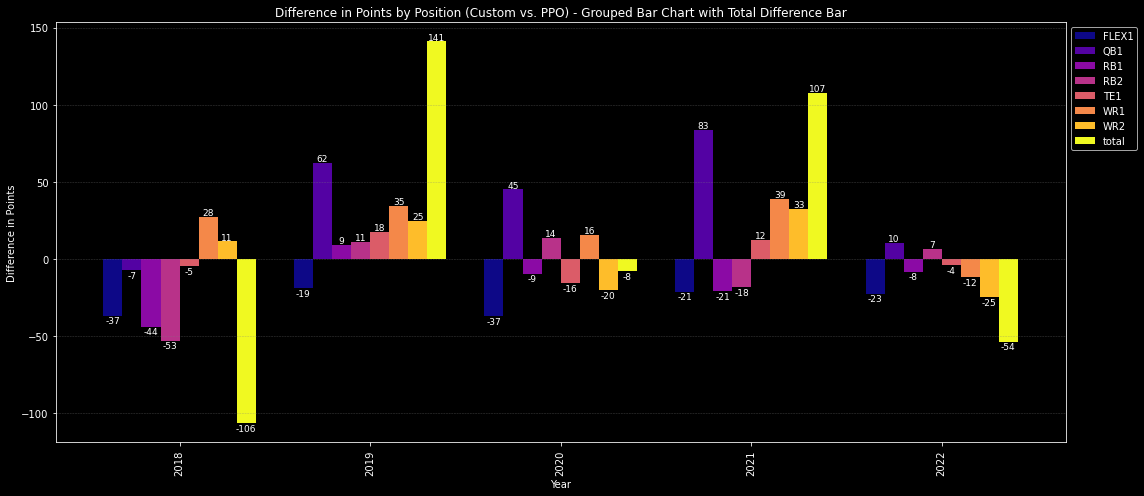

In [6]:
grouped_df = groupby.groupby(['year', 'roster_position'])['difference'].mean().unstack()

# Adjust bar width for both grouped bars and total bars
bar_width = 0.8 / len(grouped_df.columns)

# Plotting the grouped bar chart with adjusted label positioning for negative values
ax = grouped_df.plot(kind='bar', figsize=(15, 7), width=0.8, colormap='plasma')

# Adjusting data label positioning for accurate centering
for i, year in enumerate(grouped_df.index):
    for j, pos in enumerate(grouped_df.columns):
        value = grouped_df.loc[year, pos]
        x_position = i + j * bar_width - (bar_width * len(grouped_df.columns) / 2) + bar_width / 2
        y_offset = 1  # default offset
        if value < 0:
            y_offset = 5  # larger offset for negative values
        y_position = value + (y_offset if value > 0 else -y_offset)
        ax.text(x_position, y_position, f"{value:.0f}", ha='center', fontsize=9, color='white')

plt.title('Difference in Points by Position (Custom vs. PPO) - Grouped Bar Chart with Total Difference Bar')
plt.ylabel('Difference in Points')
plt.xlabel('Year')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [7]:
import plotly.express as px

grouped_df = groupby.groupby(['year', 'roster_position'])['difference'].mean().reset_index()
grouped_df = grouped_df[grouped_df['roster_position'] != 'total']

pivot_df = grouped_df.pivot(index='year', columns='roster_position', values='difference').reset_index()

# Calculate the total difference for each year
pivot_df['total_difference'] = pivot_df.drop(columns='year').sum(axis=1)

def custom_hover_data(row):
    hover_text = [f"Year: {int(row['year'])}", f"Total Difference: {row['total_difference']:.2f}"]
    for position, value in row.items():
        if position != "year" and position != "total_difference":
            hover_text.append(f"{position}: {value:.2f}")
    return '<br>'.join(hover_text)

pivot_df['hover_text'] = pivot_df.apply(custom_hover_data, axis=1)

melted_df = pivot_df.melt(id_vars=['year', 'hover_text', 'total_difference'], value_name='difference', var_name='roster_position')

fig = px.bar(melted_df, x='year', y='difference', color='roster_position', title='Difference in Points by Position (Custom vs. PPO)',
             labels={'difference': 'Difference in Points'},
             hover_data={'hover_text': True, 'roster_position': False, 'difference': False},
             hover_name='hover_text',
             color_discrete_sequence=px.colors.sequential.Plasma,
             text='difference')

# Update the layout to show the positional differences on the bars and adjust the hover template
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False, hovertemplate='%{hovertext}')

# Show the plot
fig.show()

In [8]:
data = pd.read_csv('data/drafts/ppo_vs_custom.csv')

grouped_data = data.groupby(['year', 'roster_position'])['difference'].mean().reset_index()
pivot_table = grouped_data.pivot(index='roster_position', columns='year', values='difference')
pivot_table['Total'] = pivot_table.mean(axis=1)
pivot_table = pivot_table.round(0).astype(int)

pivot_table

year,2018,2019,2020,2021,2022,Total
roster_position,,,,,,
FLEX1,-37,-19,-37,-21,-23,-27
QB1,-7,62,45,83,10,39
RB1,-44,9,-9,-21,-8,-15
RB2,-53,11,14,-18,7,-8
TE1,-5,18,-16,12,-4,1
WR1,28,35,16,39,-12,21
WR2,11,25,-20,33,-25,5
total,-106,141,-8,107,-54,16
